# Lecture 13 - Code Implementation of GMMs with the EM Algorithm & Discussions on Hyperparameter estimation

---

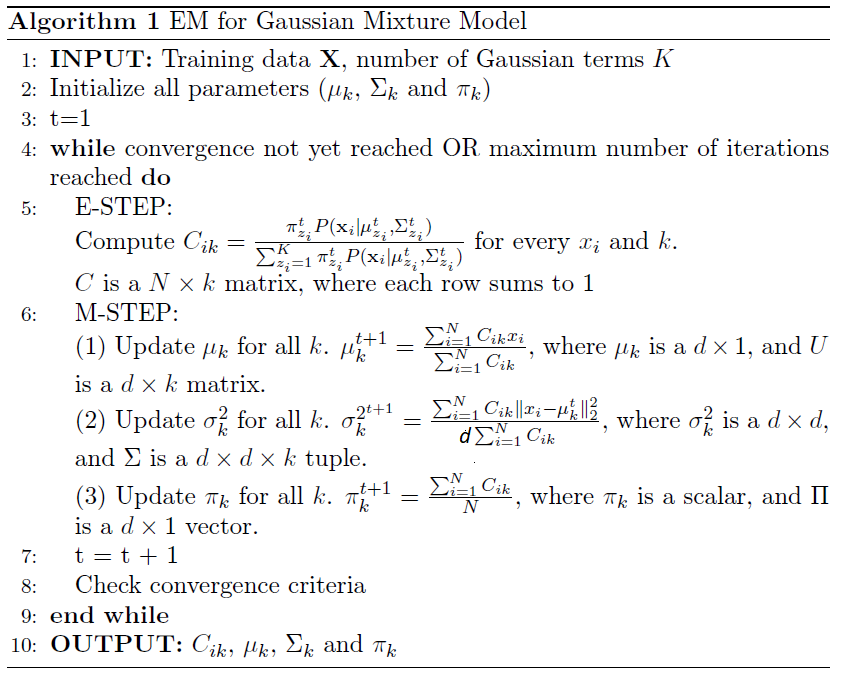

In [1]:
from IPython.display import Image
Image('figures/PseudoCode_EMforGMM.png',width=700)

___

## Example: GMM as Density Estimation

Consider some data generated from Scikit-Learn's ```make_moons``` function:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

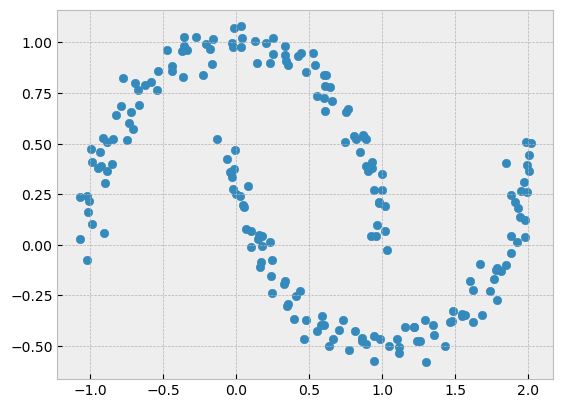

In [3]:
from sklearn.datasets import make_moons
from matplotlib.patches import Ellipse

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Let's create a helper function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output. 

* Let's not worry about the implementation of this helper function.

In [4]:
# Code from "Python Data Science Handbook"
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

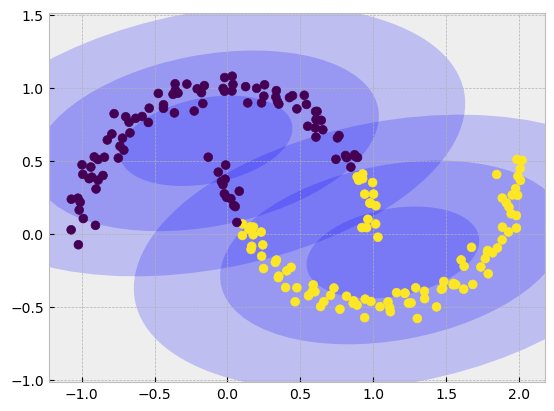

In [5]:
from sklearn.mixture import GaussianMixture

GMM = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(Xmoon)
plot_gmm(GMM, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

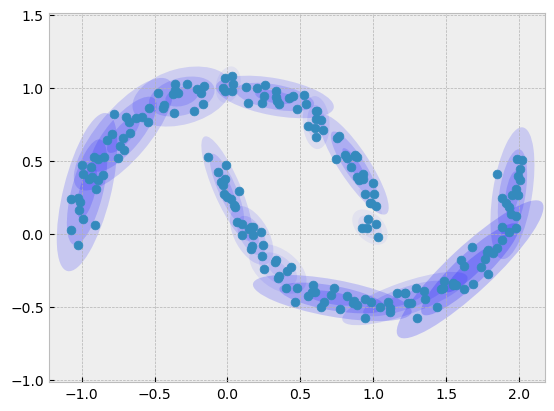

In [6]:
GMM16 = GaussianMixture(n_components=16, random_state=0).fit(Xmoon)
plot_gmm(GMM16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. 

For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

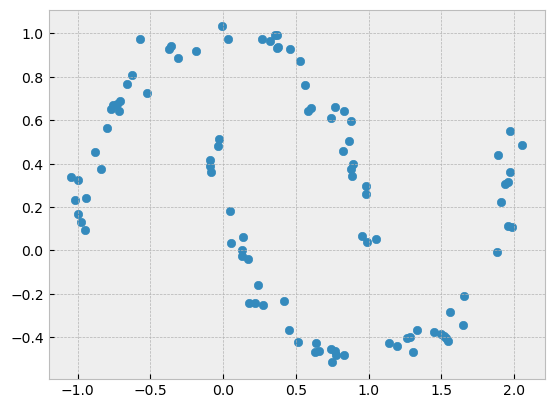

In [7]:
Xnew = GMM16.sample(100)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

---

## Example: GMM as a Clustering Algorithm

GMM is commonly used as an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

However, a common practical use for the GMM is as a clustering algorithm, where we are interested in finding groups in the data.

To illustrate this, I will use the ```scikit-learn``` algorithm implementation of the GMM model:

In [8]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

# Create synthetically generate data
n_samples = 1500
X1, T1 = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1)               # Blobs data
X2, T2 = datasets.make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5],centers=3) # Different Variance Blobs data
X3, T3 = datasets.make_moons(n_samples=n_samples, noise=.05)                            # Moons data
X4, T4 = datasets.make_circles(n_samples, noise=.05, factor=0.5)                        # Circles data
X5     = np.dot(X1, [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]])             # Anisotropicly distributed data
T5     = T1
X6     = np.vstack((X1[T1 == 0][:500], X1[T1 == 1][:100], X1[T1 == 2][:10]))            # Unevenly sized Blobs data
T6     = np.hstack((np.zeros(500),np.ones(100),2*np.ones(10))).astype('int')

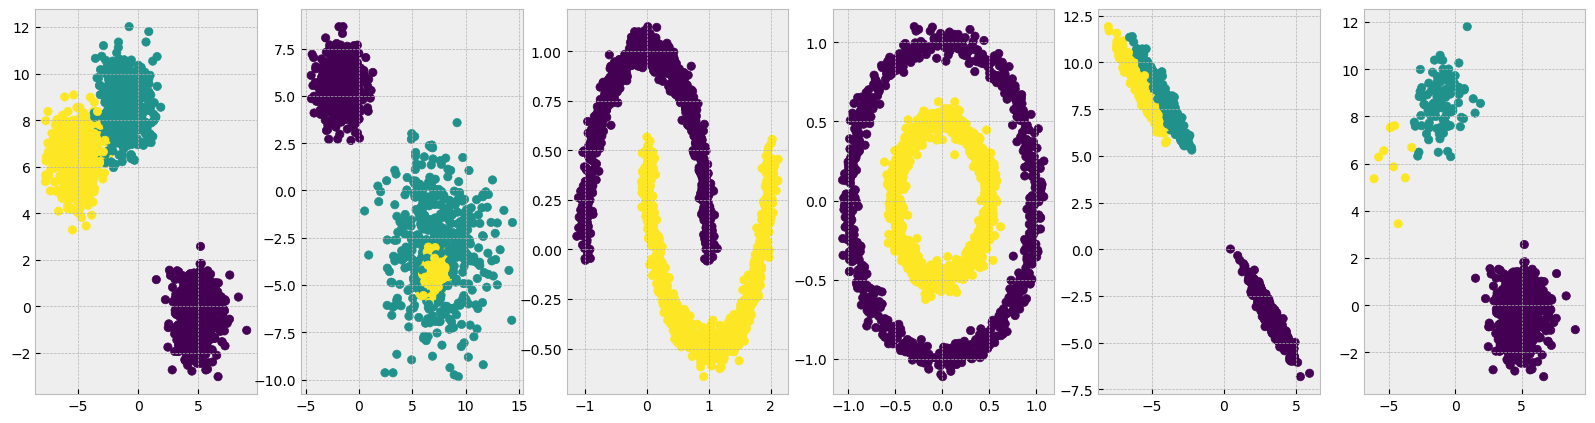

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(1,6,1); plt.scatter(X1[:,0],X1[:,1],c=T1)
plt.subplot(1,6,2); plt.scatter(X2[:,0],X2[:,1],c=T2)
plt.subplot(1,6,3); plt.scatter(X3[:,0],X3[:,1],c=T3)
plt.subplot(1,6,4); plt.scatter(X4[:,0],X4[:,1],c=T4)
plt.subplot(1,6,5); plt.scatter(X5[:,0],X5[:,1],c=T5)
plt.subplot(1,6,6); plt.scatter(X6[:,0],X6[:,1],c=T6);

In [10]:
?GaussianMixture

In [11]:
def GMM_predict_plot(X,T,Nclusters,init_parms='kmeans',covariance_type='full'):
    
    N, D = X.shape
    
    # select mean values as random samples from dataset X
    if init_parms == 'random':
        index_loc=np.random.randint(0,N,size=Nclusters)
        means_init = X[index_loc,:]
        
        GMM = GaussianMixture(n_components=Nclusters,
                          covariance_type=covariance_type,
                              init_params=init_parms,
                             means_init=means_init).fit(X)
    
    # otherwise, initialize with k-means clustering solution
    else:
        GMM = GaussianMixture(n_components=Nclusters,
                              covariance_type=covariance_type,
                              init_params=init_parms).fit(X)
    labels = GMM.predict(X)
    prob = GMM.predict_proba(X).round(2)

    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0],X[:,1], c=T)
    plt.title('True (Unknown) Labels');
    
    fig = plt.figure(figsize=(15,10))
    fig.add_subplot(2,Nclusters,1)
    plt.scatter(X[:,0],X[:,1], c=labels)
    plt.title('Predicted Labels by GMM');
    for i in range(Nclusters):
        ax = fig.add_subplot(2,Nclusters,Nclusters+i+1)
        p1 = ax.scatter(X[:,0], X[:,1], c=prob[:,i])
        fig.colorbar(p1, ax=ax)
        plt.title('Memberships in Cluster '+str(i+1))

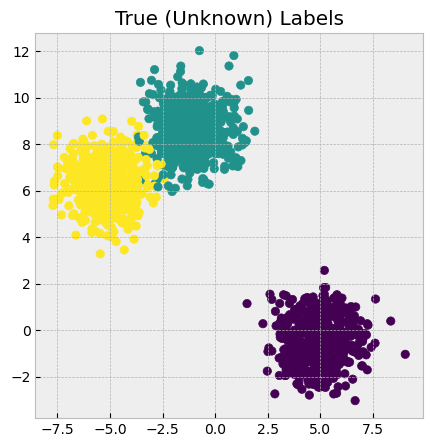

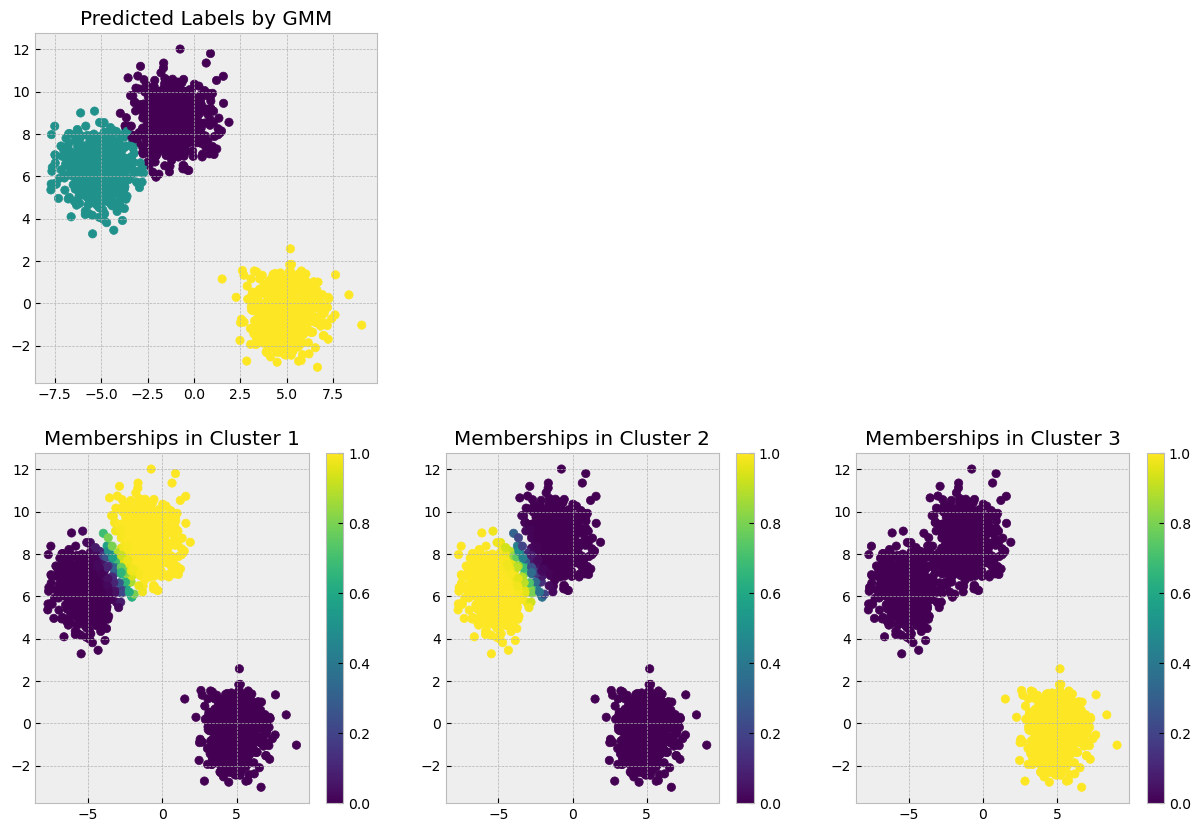

In [12]:
GMM_predict_plot(X1,T1,3,'random','diag');

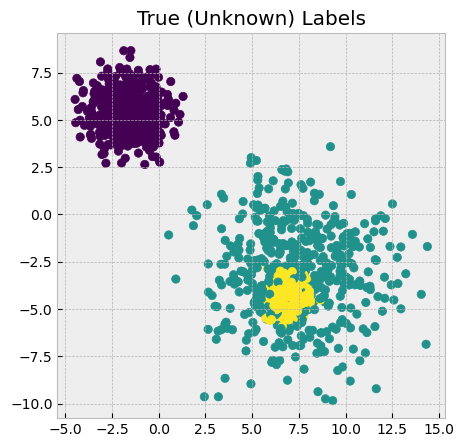

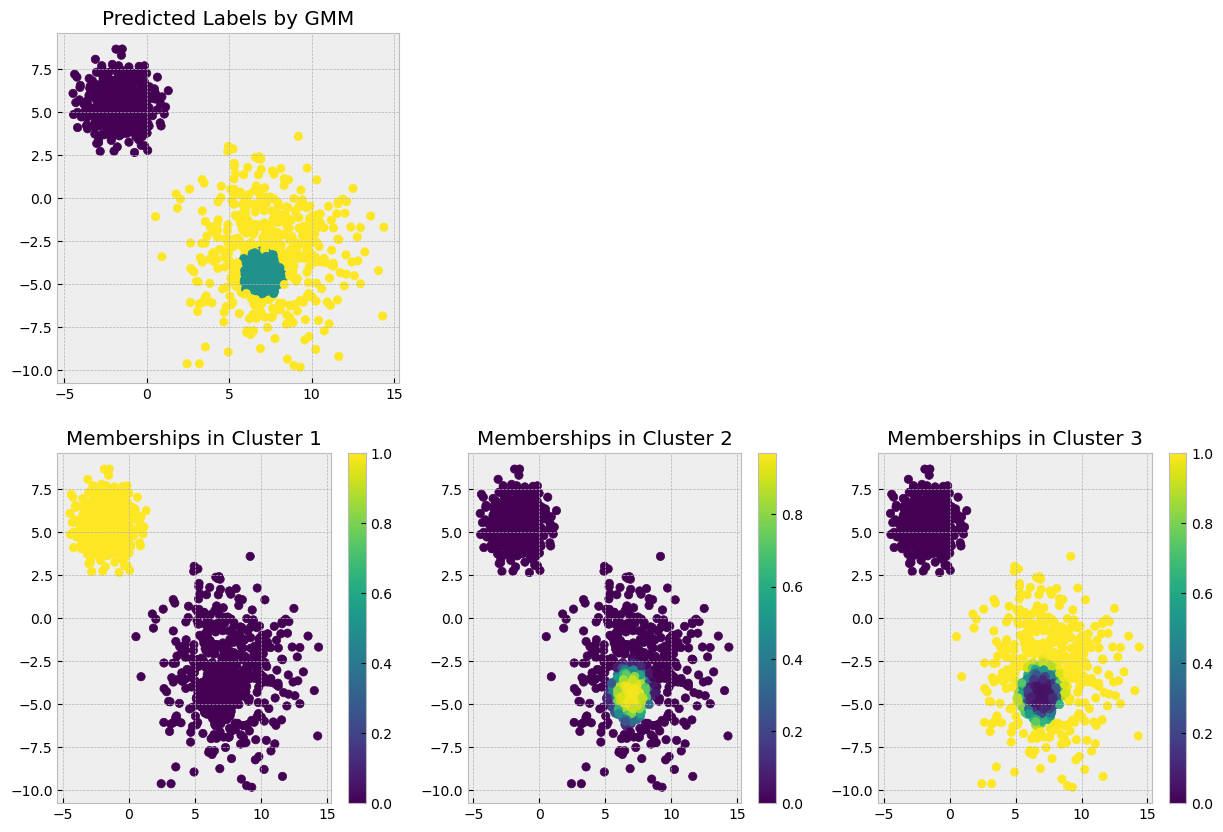

In [13]:
GMM_predict_plot(X2,T2,3)

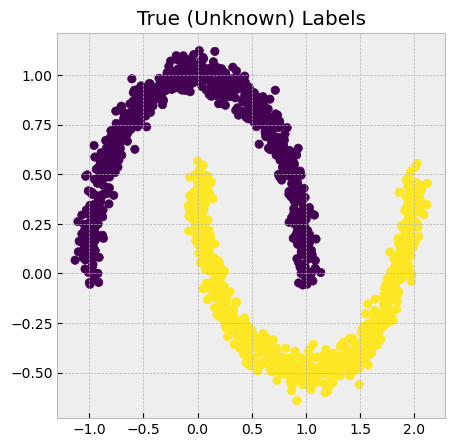

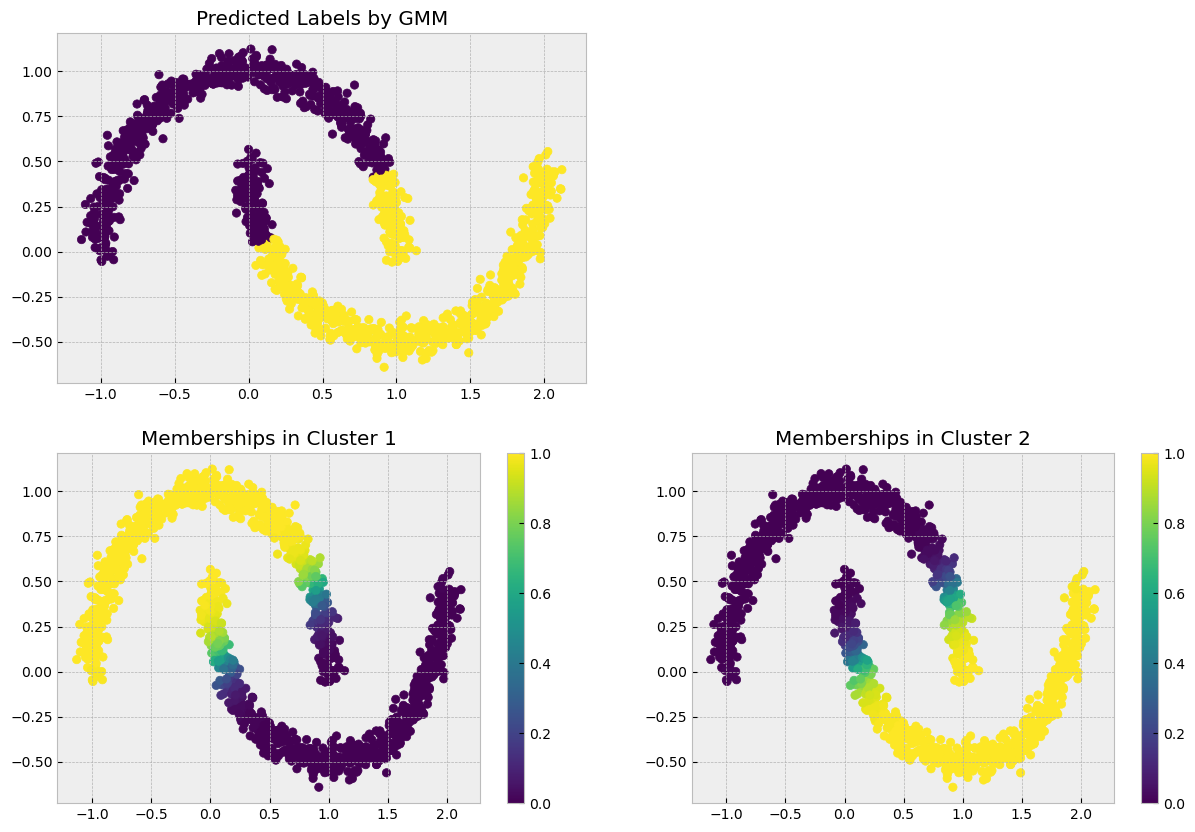

In [14]:
GMM_predict_plot(X3,T3,2)

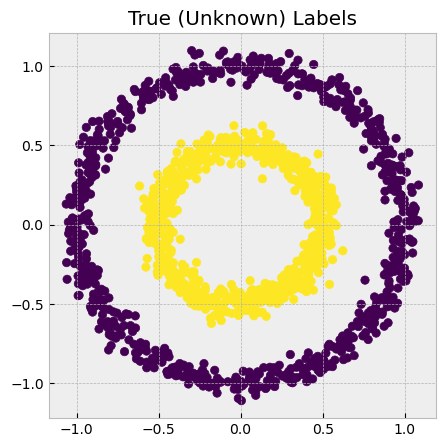

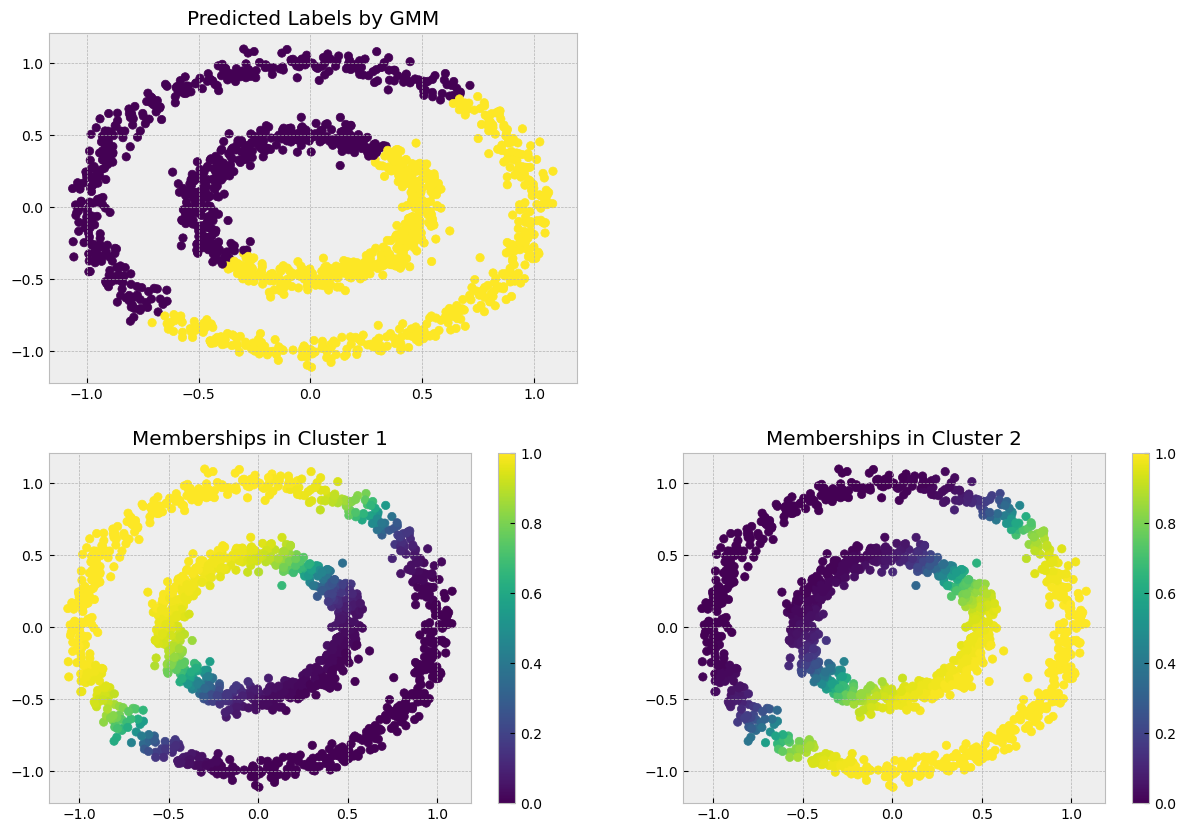

In [15]:
GMM_predict_plot(X4,T4,2)

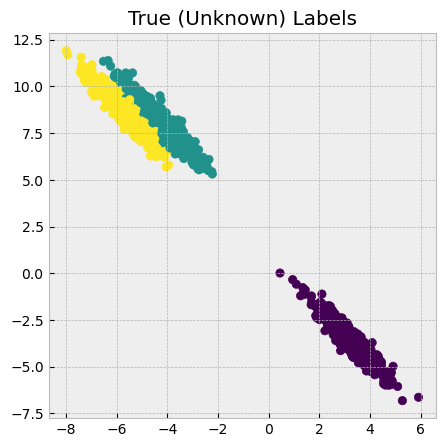

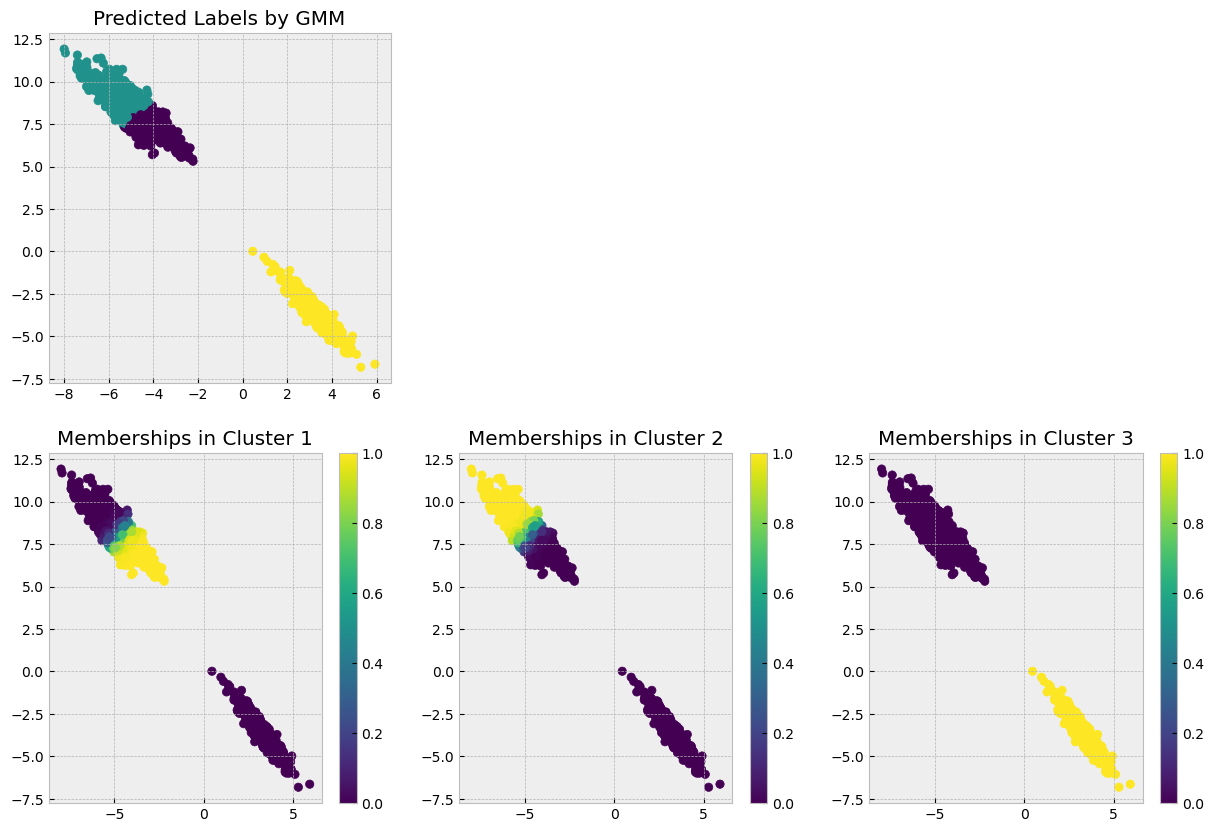

In [16]:
GMM_predict_plot(X5,T5,3,'random','diag')

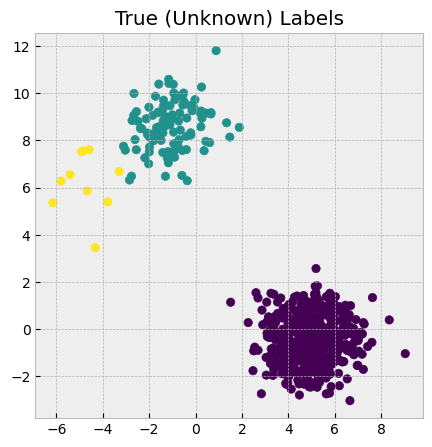

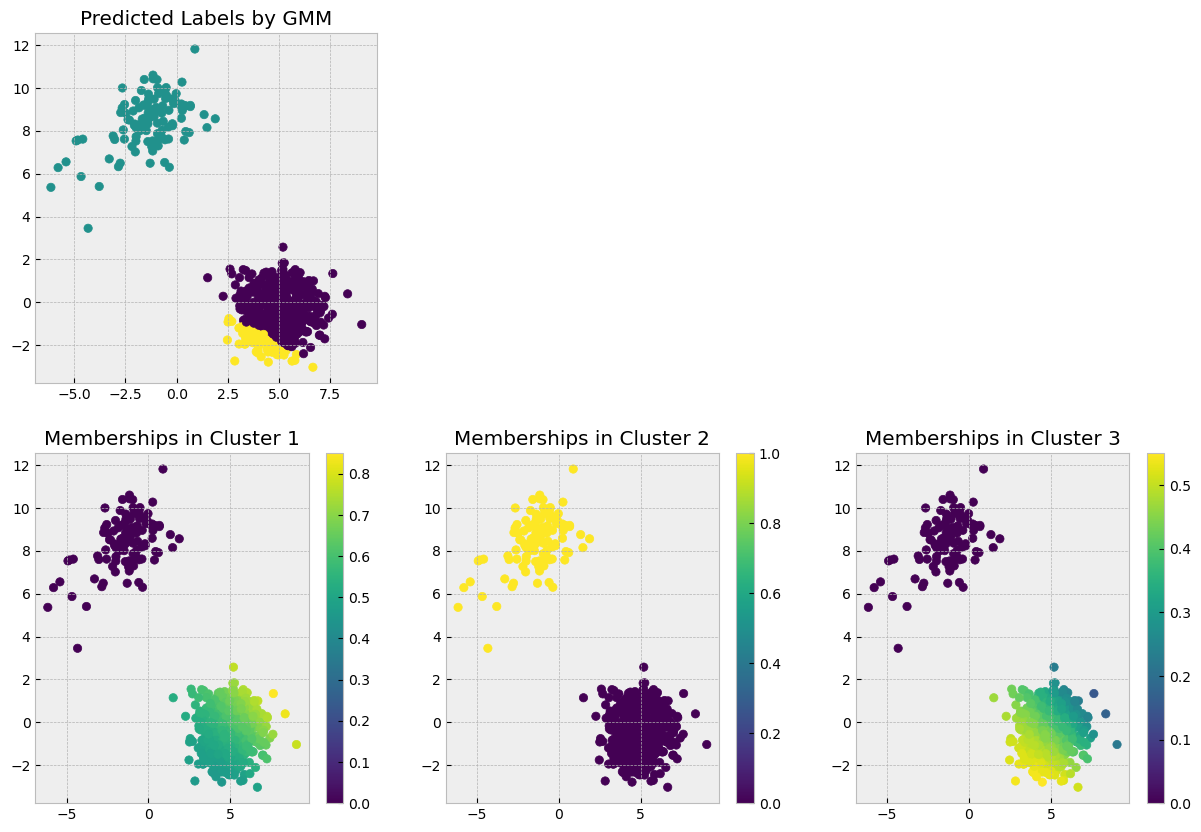

In [20]:
GMM_predict_plot(X6,T6,3,'random')

___